## Telecommunication Breakdown Concepts of Communication Transmitted via Software-Defined Radio - C. Richard Johnson Jr. • William A. Sethares

This notebook have an quick summary of the book above and will be used to solve some of the provided exercises. 

The code below is authored by me and is based on the graphical results presented in the book. The questions suggest a MATLAB code to be used, however, the work was done without relying on it.

## Introduction

- When the message is digital you need to convert it to an analog signal before transmission. This can be achieved using an filter to give the signals an analog pulse format. After transmission we need to recover it to be interpreted in digital levels;

- Some complications can be with the delay of transmission, intersymbol interference (ISI), noise and attenuation;

- To minimize the channel disturbances is necessary to choose an appropriate pulse shape besides an optimized filter on the receiver. 

## Spectrum of The Pulse

-  The shape of the pulse used for transmission dictates the spectrum of the analog signal;

*$w_a(kT)$ is an discrete-time message sequence turned into analog pulse train*

$$w_a(t) = \sum_kw(kT)\delta(t-kT) = \begin{cases} w(kT) & t = kT\\ 0 & t \neq kT \end{cases}$$

witch leads us to $x(t) = w_a(t)*p(t)$, therefore to an frequency domain multiplication $X(f) = W_a(f)P(f)$;

*$p(t)$ is the filter impulse response*

- Even when the signal transmitted is unknown it will be always directly scaled by $P(f)$, limiting the spectrum of the convoluted signal transmitted and establishing an way to recover the information.

## Intersymbol Interference

- ISI can occurs in two scenarios:
	1. When the pulse shape is wider than a single symbol interval T;
	2. When there is a nonunity channel that "*smears*" nearby pulses, causing them to overlap.
- Wider pulse shapes occupy less bandwidth, on the other hand the duration increases proportionally.

## Eye Diagrams

- The Eye Diagram is a visualization tool that shows smearing and whether symbol errors will occur ;
- As the number of superimposed traces increases, the eye diagram becomes denser and gives an simple visual way to analyze the system recovery of the transmitted message;
- The center of the eye gives us the best sampling time, the width indicates the time window where timing errors can be interpreted and the noise margin is the vertical distance between the bands, thus the limit of addictive noise amplitude acceptable.

## Nyquist Pulses

- The condition that one pulse does not interfere with other subsequent pulses is formalized by saying that $h_{NYQ} (t)$ is a Nyquist Pulse if there is a $\tau$ such that:
$$h_{NYQ}(kT+\tau) = \begin{cases} e, & k=0 \\ 0, & k\neq0 \end{cases}$$
	*for all integers k, where e is some nonzero constant*

- Therefore, the pulse chosen needs to be wide in time so the spectrum is efficiently used and fulfill the Nyquist condition to avoid ISI.

- Sinc pulse may seem charming to use in this situation, however it has several limitations:
	1. It has infinite duration (will be always truncated in real life implementations);
	2. It is noncausal (will need to be delayed in real life implementations);
	3. The band edges of the rectangular frequency function are difficult to approximate;
	4. The sinc function decays slowly, leading pulses to be very sensitive to time errors.
- Using sinc as an unrealistic solution, we may need to fix it's limitations to obtain optimal pulse shapes, we can achieve it by:
	1. Have appropriate zero crossings (be an Nyquist pulse);
	2. Have sloped band edges in the frequency domain;
	3. Decay more rapidly while maintaining a narrow profile.
- One popular option is called raised cossine-rolloff (or raised cosine) filter. It is defined by Fourier transform

$$ H_{RC}(f) = \begin{cases} 1, & |f| < f_1 \\ {\frac{1}{2}} \left({1 + cos\left[{\frac{\pi (|f|-f_1)}{2f_\vartriangle}}\right]}\right), & f_1 < |f| < B \\ 0, & |f|>B\end{cases}$$ 
where  *B is the absolute bandwidth, $f_0$ is the 6db bandwidth, equal to $\frac{1}{2T}$, or one half of the symbol rate*, $f_\vartriangle = B - f_0$, and $f_1 = f_0 - f_\vartriangle$.

- The time domain function is:
  $$h_{RC}(t) = \mathscr{F}^{-1}\{H_{RC(f)}\} = 2f_0\left(\frac{\sin(2\pi f_0t)}{2\pi f_0t}\right)\left[\frac{cos(2\pi f_\vartriangle t)}{1 - (4f_\vartriangle t)^2} \right]$$
- Define the rolloff factor $\beta = f_\vartriangle/f_0$ , when $\beta \rightarrow 0, h_{RC}(t)$ becomes a sinc. We can define the pulse by rolloff factor as: 
$$ h_{RC}(t) = \begin{cases} \frac{\pi}{4T}sinc\left(\frac{1}{2\beta}\right), & t = \pm \frac{T}{2\beta} \\ 
{\frac{1}{T}} sinc\left(\frac{t}{T}\right) \frac{cos\left(\frac{\pi\beta t}{T}\right)}{1-\left(\frac{2\beta t}{T}\right)^2}, & otherwise\end{cases}$$
$$ H_{RC}(f) = \begin{cases} 1, & |f|\leq \frac{1-\beta}{2T} \\ 
{\frac{1}{2}}\left[ 1 + cos \left(\frac{\pi T}{\beta} \left[ |f| - \frac{1-\beta}{2T}\right] \right)\right], & \frac{1-\beta}{2T} < |f| \leq \frac{1+\beta}{2T} \\ 0, & otherwise \end{cases}$$
 
- The limitations above are significantly reduced as  the band edges are less severe, zero crossings can be obtained in desired times and the envelope falls off approximately $1/|t^3|$ way better than the sinc $1|t|$ rate.
- As $\beta$ increases from 0 to 1 the significant part of the impulse gets shorter.
- An more general definition can be: If $v(t)$ is a Nyquist pulse, the only nonzero term in the summation of its Fourier transform is $v(0)$
	$$\mathscr{F}\left\{\sum^\infty _{k = -\infty} \delta(t-kT)\right\} = \frac{1}{T}\sum^\infty _{k = -\infty} \delta(f-nf_0) = \sum^\infty _{k = -\infty} V(f-nf_0)$$
	*where $f_0 = 1/T$*$$\sum^\infty _{k = -\infty} V(f-nf_0) = Tv(0)$$

In [103]:
# Imports and parameters

import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
import math
import pandas as pd
import importlib.util
import scipy.signal as sci
import numpy.lib.scimath as sp
import sympy as sp
import numpy.polynomial.polynomial as poly

π = np.pi

T = 10 # Default period

fs = 2500 # frequency used
fc = 100 # cutoff frequency
wc = 2*π*fc/fs
samples = fs
t = np.linspace(0, samples, 10*samples) # defining array of time

pam = [-3, -1, 1, 3]

signal = np.ones(len(t))

# create an random array between pam values and repeat the value 25 times
signal = np.random.choice(pam, size=int(len(t)/25))
signal = np.repeat(signal, 25)

#### Question 11.1
*Modify **pulsespec.m** to reproduce Figures 11.4 and 11.5 for the double-wide pulse shape.*

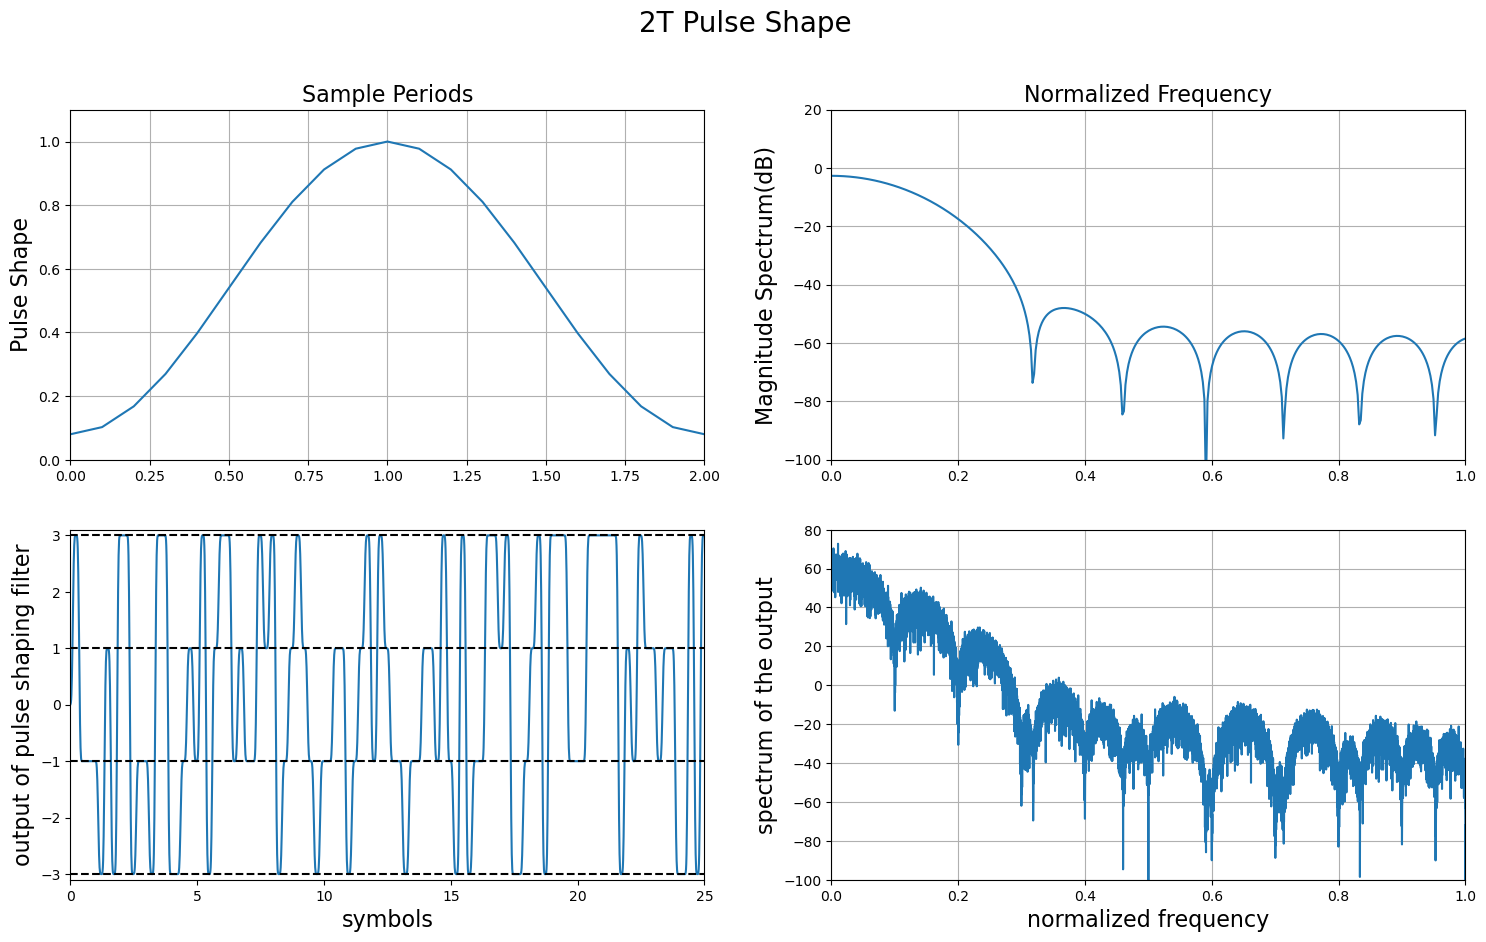

In [104]:
# using double-wide pulse shape
N = 2*T # choosing the coeficients, as T = 10 
M = int(N/2)

pulse = np.zeros(N+1)

for i in range(N+1): # creating the window
    pulse[i] = 0.54 - 0.46*np.cos(2*π*i/N)

coeficients = np.zeros(N+1)

for i in range(N+1): # creating the filter
    if i == M:
        coeficients[M] = pulse[i]*wc/π # creating the middle term
    else:
        coeficients[i] = pulse[i]*((np.sin(wc*(i-M)))/(π*(i-M)))

# plot generation

figure1, ax = plt.subplots(2,2, figsize=(18,10)) 

freq, H = sci.freqz(coeficients, fs=fs)

x = np.linspace(0,N/10,len(pulse))

plt.suptitle('2T Pulse Shape', fontsize=20)
ax[0,0].plot(x,pulse)
ax[0,0].set_title('Sample Periods', size = 16)
ax[0,0].set_ylabel('Pulse Shape', size = 16)
ax[0,0].set_xlim(0,N/10)
ax[0,0].set_ylim(0,1.1)
ax[0,0].grid()

ax[0,1].plot(freq/1000, 20*np.log10(abs(H)))
ax[0,1].set_title('Normalized Frequency', size = 16)
ax[0,1].set_ylabel('Magnitude Spectrum(dB)', size = 16)
ax[0,1].set_xlim(0,1)
ax[0,1].set_ylim(-100,20)
ax[0,1].grid()

conv = sci.fftconvolve(signal,coeficients) # convoluting the filter and signal

fft_result = np.fft.fft(conv) # generating fft of the result
f_result = np.fft.fftfreq(len(conv), 1/(fs))
f_result = np.fft.fftshift(f_result)


ax[1,0].plot(t[0:2500]/10,conv[0:2500]*3/conv.max()) #normalizing the convolution function gain 
ax[1,0].set_xlim(0,25)
ax[1,0].set_ylim(-3.1,3.1)
ax[1,0].set_xlabel('symbols', fontsize = 16)
ax[1,0].set_ylabel('output of pulse shaping filter', fontsize = 16)
ax[1,0].axhline(y=3, color ='k', linestyle = '--')
ax[1,0].axhline(y=1., color ='k', linestyle = '--')
ax[1,0].axhline(y=-1, color ='k', linestyle = '--')
ax[1,0].axhline(y=-3, color ='k', linestyle = '--')

ax[1,1].plot(f_result[12510::]/1000, 20*np.log10(abs(fft_result[0:12510])), label = 'Filtered signal' )
ax[1,1].set_xlim(0,1)
ax[1,1].set_ylim(-100,80)
ax[1,1].set_xlabel('normalized frequency', fontsize = 16)
ax[1,1].set_ylabel('spectrum of the output', fontsize = 16)
ax[1,1].grid()


Due to the symbols have 2.5 period band, the 2 period pulse can transmit the information without generating ISI, thus this filter is more appropriate for the signal than the 3 period used on the book.

#### Question 11.2
*Modify **pulsespec.m** to examine what happens when a Hamming pulse shape of width 4T, 6T and 10T are used. What is the bandwidth of the resulting transmitted signals? Do you think it is possible to recover the massage from recieved signals? Explain.*

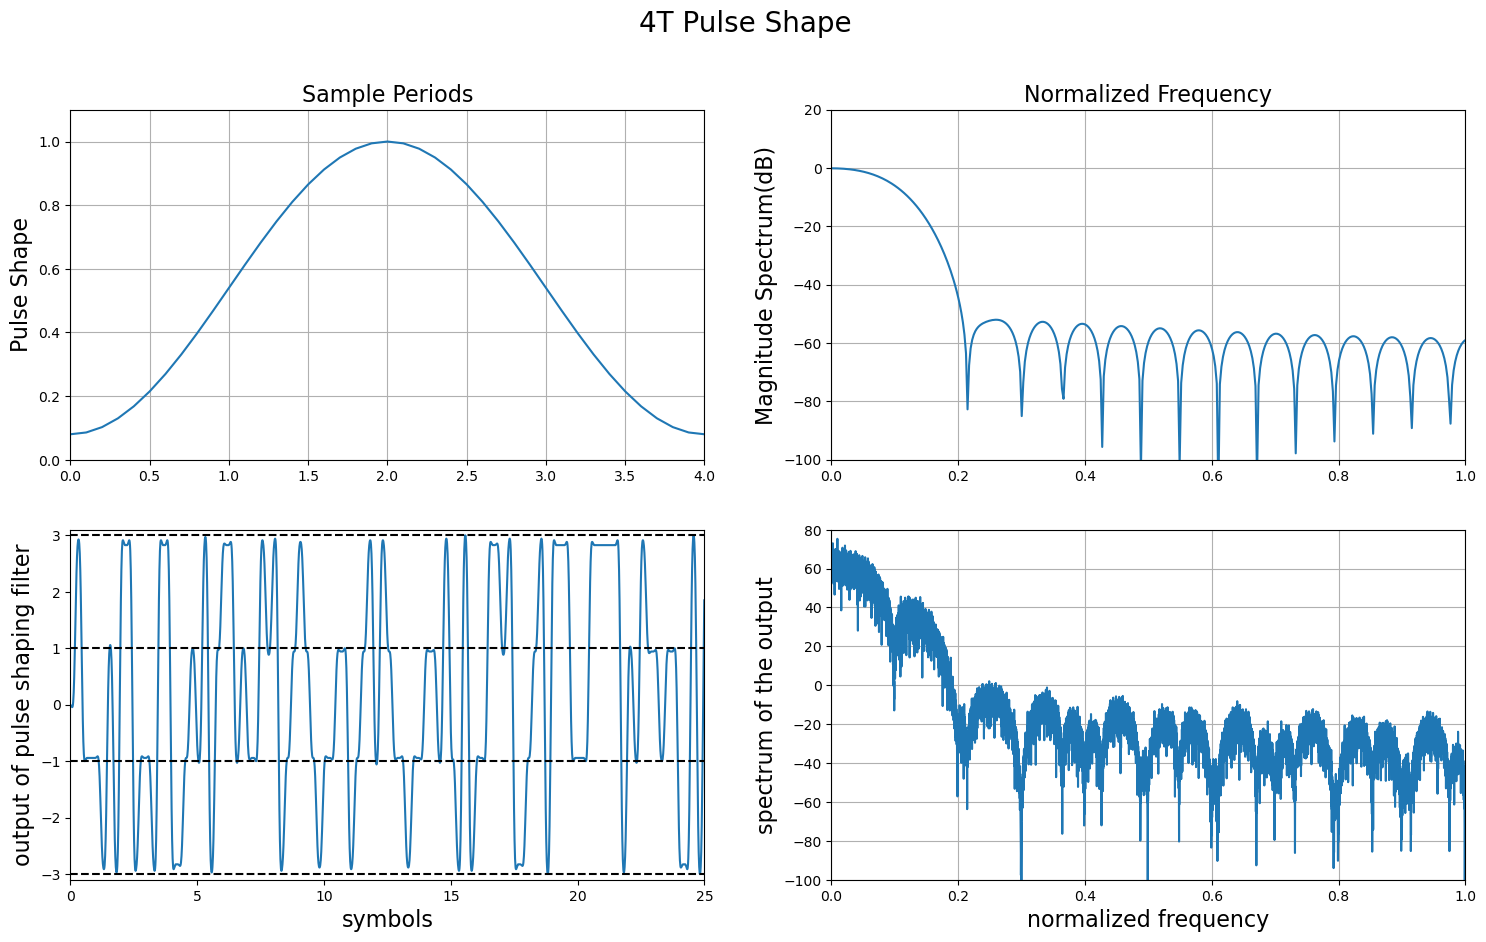

In [105]:
# using 4T pulse shape
N = 4*T # choosing the coeficients, as T = 10 
M = int(N/2)

pulse = np.zeros(N+1)

for i in range(N+1): # creating the window
    pulse[i] = 0.54 - 0.46*np.cos(2*π*i/N)

coeficients = np.zeros(N+1)

for i in range(N+1): # creating the filter
    if i == M:
        coeficients[M] = pulse[i]*wc/π # creating the middle term
    else:
        coeficients[i] = pulse[i]*((np.sin(wc*(i-M)))/(π*(i-M)))

# plot generation

figure2, ax = plt.subplots(2,2, figsize=(18,10)) 

freq, H = sci.freqz(coeficients, fs=fs)

x = np.linspace(0,N/10,len(pulse))


plt.suptitle('4T Pulse Shape', fontsize=20)
ax[0,0].plot(x,pulse)
ax[0,0].set_title('Sample Periods', size = 16)
ax[0,0].set_ylabel('Pulse Shape', size = 16)
ax[0,0].set_xlim(0,N/10)
ax[0,0].set_ylim(0,1.1)
ax[0,0].grid()

ax[0,1].plot(freq/1000, 20*np.log10(abs(H)))
ax[0,1].set_title('Normalized Frequency', size = 16)
ax[0,1].set_ylabel('Magnitude Spectrum(dB)', size = 16)
ax[0,1].set_xlim(0,1)
ax[0,1].set_ylim(-100,20)
ax[0,1].grid()

conv = sci.fftconvolve(signal,coeficients) # convoluting the filter and signal

fft_result = np.fft.fft(conv) # generating fft of the result
f_result = np.fft.fftfreq(len(conv), 1/(fs))
f_result = np.fft.fftshift(f_result)


ax[1,0].plot(t[0:2500]/10,conv[0:2500]*3/conv.max()) #normalizing the convolution function gain 
ax[1,0].set_xlim(0,25)
ax[1,0].set_ylim(-3.1,3.1)
ax[1,0].set_xlabel('symbols', fontsize = 16)
ax[1,0].set_ylabel('output of pulse shaping filter', fontsize = 16)
ax[1,0].axhline(y=3, color ='k', linestyle = '--')
ax[1,0].axhline(y=1., color ='k', linestyle = '--')
ax[1,0].axhline(y=-1, color ='k', linestyle = '--')
ax[1,0].axhline(y=-3, color ='k', linestyle = '--')

ax[1,1].plot(f_result[12510::]/1000, 20*np.log10(abs(fft_result[0:12530])), label = 'Filtered signal' )
ax[1,1].set_xlim(0,1)
ax[1,1].set_ylim(-100,80)
ax[1,1].set_xlabel('normalized frequency', fontsize = 16)
ax[1,1].set_ylabel('spectrum of the output', fontsize = 16)
ax[1,1].grid()


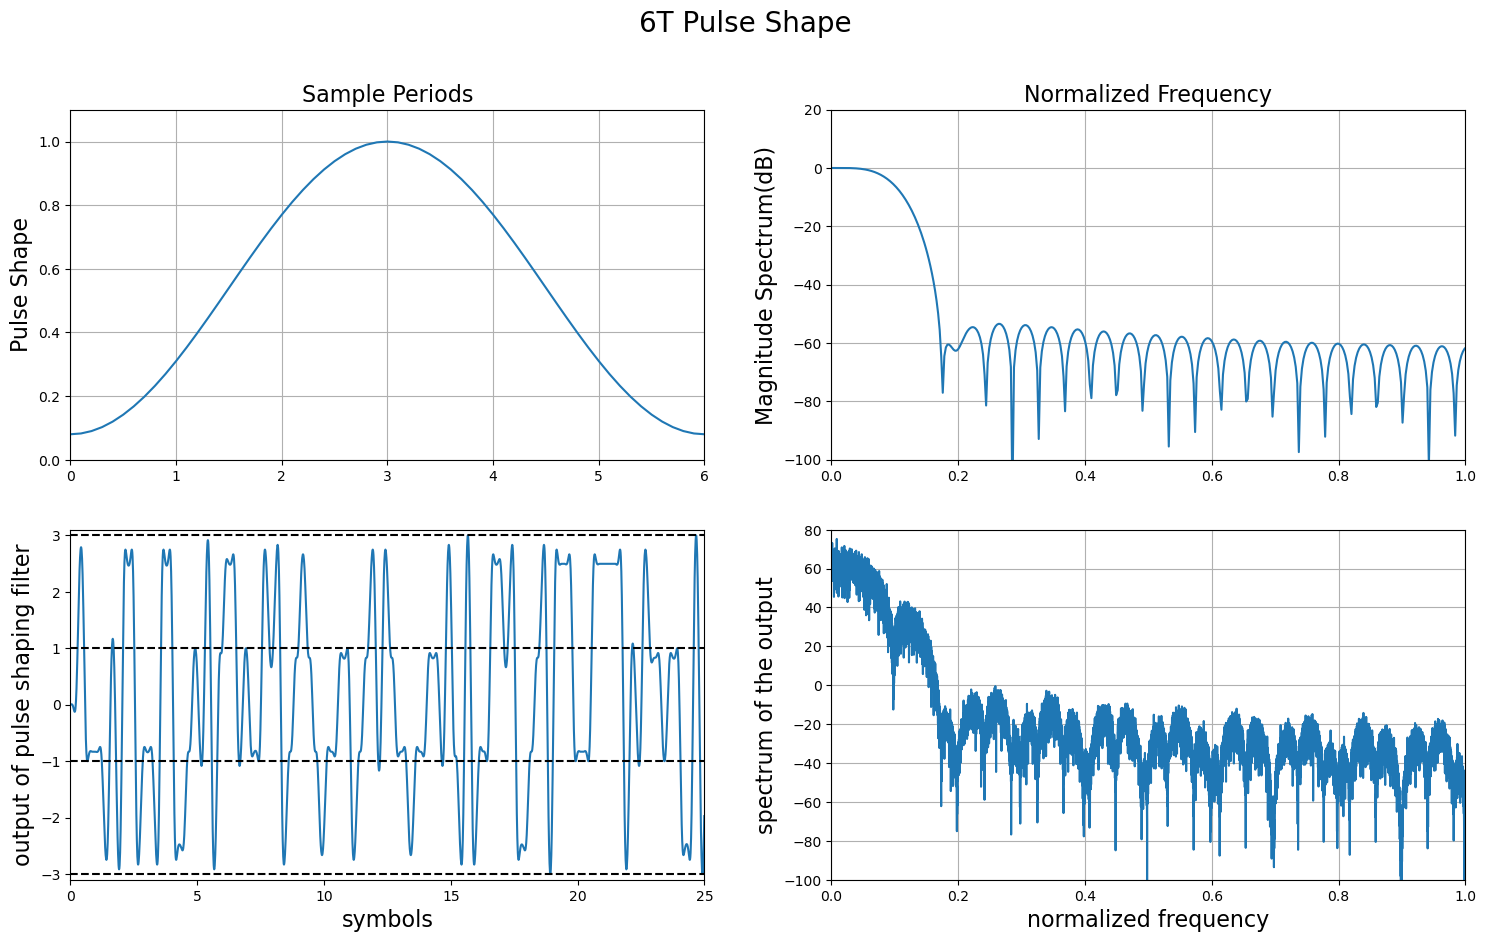

In [106]:
# using 6T pulse shape
N = 6*T # choosing the coeficients, as T = 10 
M = int(N/2)

pulse = np.zeros(N+1)

for i in range(N+1): # creating the window
    pulse[i] = 0.54 - 0.46*np.cos(2*π*i/N)

coeficients = np.zeros(N+1)

for i in range(N+1): # creating the filter
    if i == M:
        coeficients[M] = pulse[i]*wc/π # creating the middle term
    else:
        coeficients[i] = pulse[i]*((np.sin(wc*(i-M)))/(π*(i-M)))

# plot generation

figure3, ax = plt.subplots(2,2, figsize=(18,10)) 

freq, H = sci.freqz(coeficients, fs=fs)

x = np.linspace(0,N/10,len(pulse))

plt.suptitle('6T Pulse Shape', fontsize=20)
ax[0,0].plot(x,pulse)
ax[0,0].set_title('Sample Periods', size = 16)
ax[0,0].set_ylabel('Pulse Shape', size = 16)
ax[0,0].set_xlim(0,N/10)
ax[0,0].set_ylim(0,1.1)
ax[0,0].grid()

ax[0,1].plot(freq/1000, 20*np.log10(abs(H)))
ax[0,1].set_title('Normalized Frequency', size = 16)
ax[0,1].set_ylabel('Magnitude Spectrum(dB)', size = 16)
ax[0,1].set_xlim(0,1)
ax[0,1].set_ylim(-100,20)
ax[0,1].grid()

conv = sci.fftconvolve(signal,coeficients) # convoluting the filter and signal

fft_result = np.fft.fft(conv) # generating fft of the result
f_result = np.fft.fftfreq(len(conv), 1/(fs))
f_result = np.fft.fftshift(f_result)


ax[1,0].plot(t[0:2500]/10,conv[0:2500]*3/conv.max()) #normalizing the convolution function gain 
ax[1,0].set_xlim(0,25)
ax[1,0].set_ylim(-3.1,3.1)
ax[1,0].set_xlabel('symbols', fontsize = 16)
ax[1,0].set_ylabel('output of pulse shaping filter', fontsize = 16)
ax[1,0].axhline(y=3, color ='k', linestyle = '--')
ax[1,0].axhline(y=1., color ='k', linestyle = '--')
ax[1,0].axhline(y=-1, color ='k', linestyle = '--')
ax[1,0].axhline(y=-3, color ='k', linestyle = '--')

ax[1,1].plot(f_result[12510::]/1000, 20*np.log10(abs(fft_result[0:12550])), label = 'Filtered signal' )
ax[1,1].set_xlim(0,1)
ax[1,1].set_ylim(-100,80)
ax[1,1].set_xlabel('normalized frequency', fontsize = 16)
ax[1,1].set_ylabel('spectrum of the output', fontsize = 16)
ax[1,1].grid()


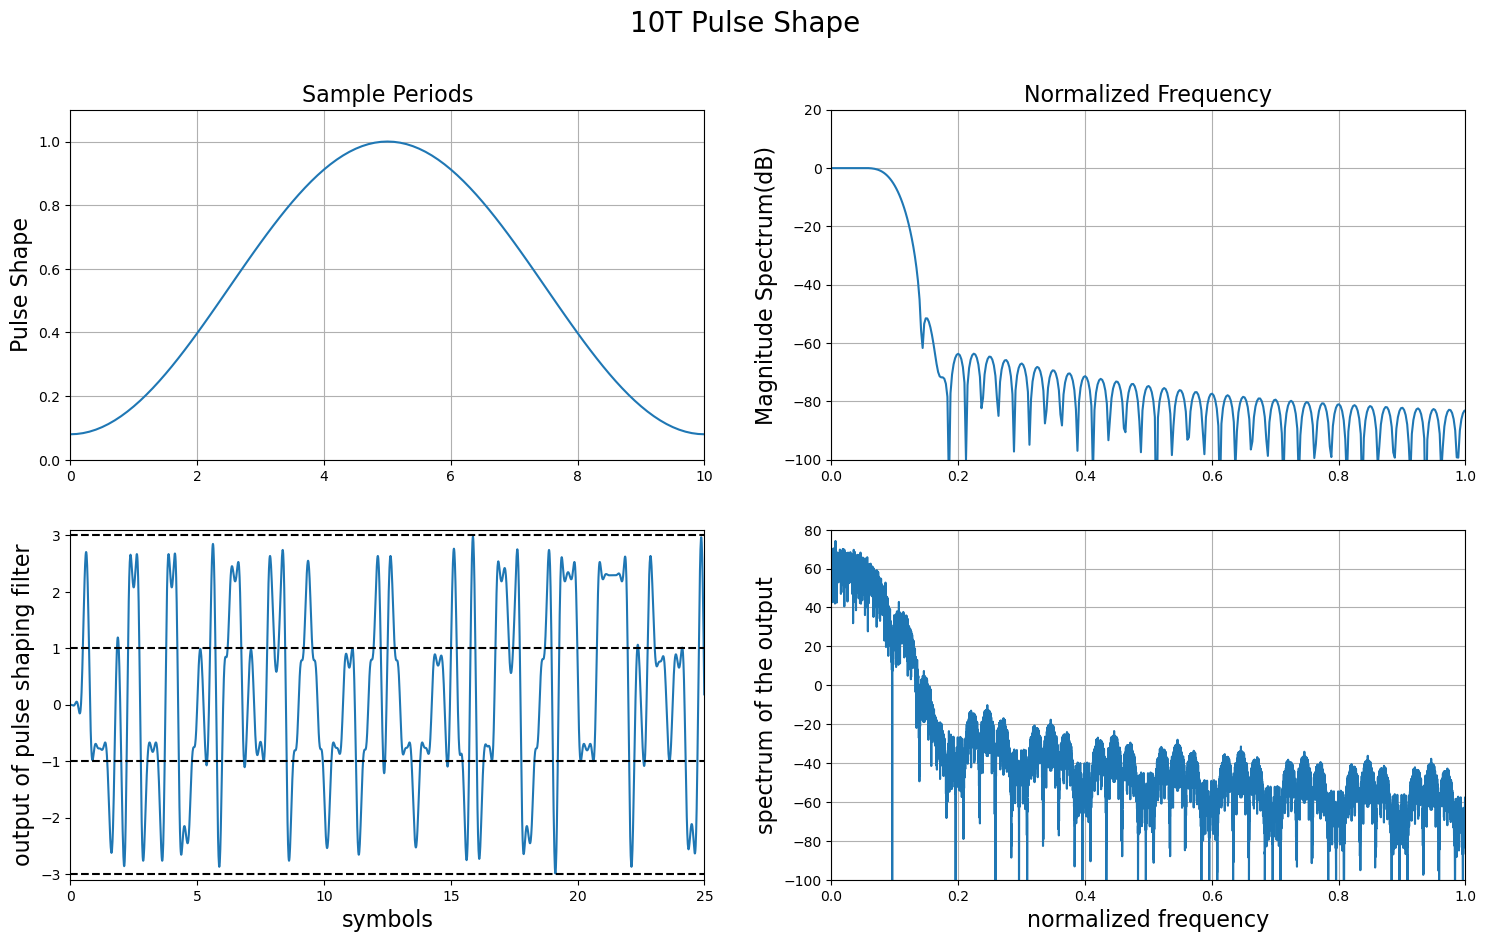

In [107]:
# using 10T pulse shape
N = 10*T # choosing the coeficients, as T = 10 
M = int(N/2)

pulse = np.zeros(N+1)

for i in range(N+1): # creating the window
    pulse[i] = 0.54 - 0.46*np.cos(2*π*i/N)

coeficients = np.zeros(N+1)

for i in range(N+1): # creating the filter
    if i == M:
        coeficients[M] = pulse[i]*wc/π # creating the middle term
    else:
        coeficients[i] = pulse[i]*((np.sin(wc*(i-M)))/(π*(i-M)))

# plot generation

figure4, ax = plt.subplots(2,2, figsize=(18,10)) 

freq, H = sci.freqz(coeficients, fs=fs)

x = np.linspace(0,N/10,len(pulse))

plt.suptitle('10T Pulse Shape', fontsize=20)
ax[0,0].plot(x,pulse)
ax[0,0].set_title('Sample Periods', size = 16)
ax[0,0].set_ylabel('Pulse Shape', size = 16)
ax[0,0].set_xlim(0,N/10)
ax[0,0].set_ylim(0,1.1)
ax[0,0].grid()

ax[0,1].plot(freq/1000, 20*np.log10(abs(H)))
ax[0,1].set_title('Normalized Frequency', size = 16)
ax[0,1].set_ylabel('Magnitude Spectrum(dB)', size = 16)
ax[0,1].set_xlim(0,1)
ax[0,1].set_ylim(-100,20)
ax[0,1].grid()

conv = sci.fftconvolve(signal,coeficients) # convoluting the filter and signal

fft_result = np.fft.fft(conv) # generating fft of the result
f_result = np.fft.fftfreq(len(conv), 1/(fs))
f_result = np.fft.fftshift(f_result)


ax[1,0].plot(t[0:2500]/10,conv[0:2500]*3/conv.max()) #normalizing the convolution function gain 
ax[1,0].set_xlim(0,25)
ax[1,0].set_ylim(-3.1,3.1)
ax[1,0].set_xlabel('symbols', fontsize = 16)
ax[1,0].set_ylabel('output of pulse shaping filter', fontsize = 16)
ax[1,0].axhline(y=3, color ='k', linestyle = '--')
ax[1,0].axhline(y=1., color ='k', linestyle = '--')
ax[1,0].axhline(y=-1, color ='k', linestyle = '--')
ax[1,0].axhline(y=-3, color ='k', linestyle = '--')

ax[1,1].plot(f_result[12510::]/1000, 20*np.log10(abs(fft_result[0:12590])), label = 'Filtered signal' )
ax[1,1].set_xlim(0,1)
ax[1,1].set_ylim(-100,80)
ax[1,1].set_xlabel('normalized frequency', fontsize = 16)
ax[1,1].set_ylabel('spectrum of the output', fontsize = 16)
ax[1,1].grid()


As the duration of the pulse increases, the severity of inter-symbol interference (ISI) escalates, potentially overwhelming the system. This occurs because the overlapping of symbols leads to received values becoming ambiguous, to the point that attempting to interpret any symbol could result in an error.

#### Question 11.14
Write a Matlab routine that implements the raised cosine impulse response (11.4) with rolloff parameter ß. Hint: If you have trouble with “divide by zero" errors, imitate the code in SRRC.m. Plot the output of your program for a variety of ß. Hint 2: There is an easy way to use the function SRRC.m.

In [108]:
# Define the function
def raised_cosine_pulse(SpS, β, T, ns):

    """
    Parameters:
        SpS (int): Number of samples per symbol.
        β (float): Rolloff factor.
        T (float): Period.
        ns (int):  Number of samples.
        
    Returns:
        pulse (np.array): Raised cosine pulse.

    """
    # Create the function time
    t = np.linspace(-ns*T/4, ns*T/4, ns*SpS)

    if β == 0: # Create raised cosine signal by it's cases
        hRC = np.sinc(t/T)/T
        
    else:
        
        hRC = (1/T)*np.sinc(t/T)*(np.cos(π*β*t/T)/(1-(2*β*t/T)**2))
        hRC[t == T/(2*β)] = (π/(4*T))*np.sinc(1/(2*β))
        hRC[t ==-T/(2*β)] = (π/(4*T))*np.sinc(1/(2*β))
        

    return hRC # Return the raised cosine generated

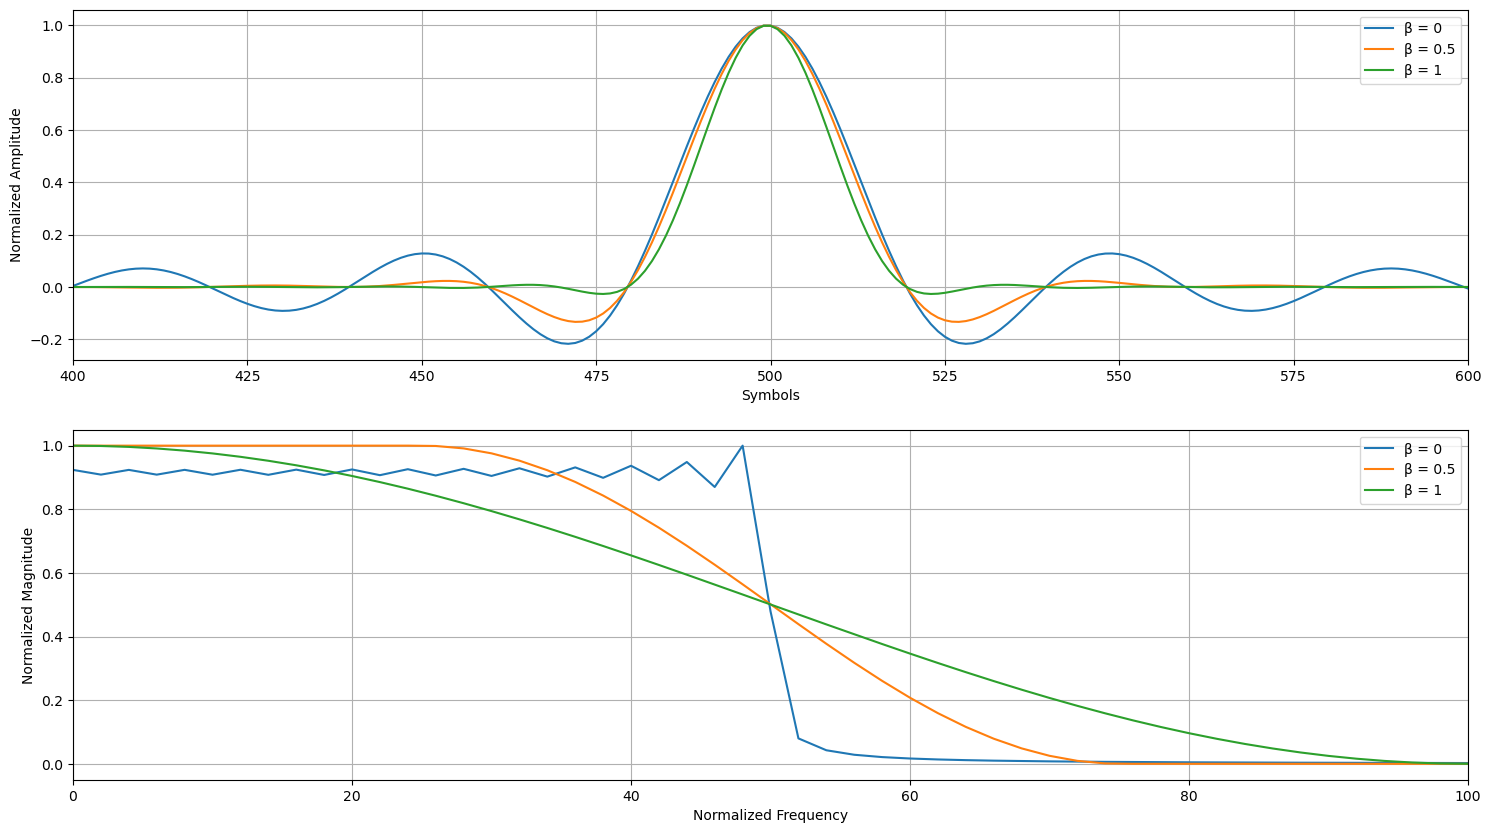

In [121]:
# Generate the plot testing the function above

figure4, ax = plt.subplots(2,1, figsize=(18,10))

# Test parameters
SpS = 10
β = [0, 0.5, 1]
T = 1
ns = 100

# Creating void arrays
w = np.zeros(ns*SpS); h = w; pulse = w


for i in range(len(β)):
    pulse = raised_cosine_pulse(SpS, β[i], T, ns) # use the function above to generate the pulse
    fft_result = np.fft.fft(pulse) # generating fft of the result
    f_result = np.fft.fftfreq(len(pulse), 1/(ns*2*SpS)) # get the frequancy
    f_result = np.unwrap(f_result)
    
    ax[0].plot(pulse, label = 'β = '+str(β[i]))

    ax[1].plot(f_result, abs(fft_result)/(abs(fft_result.max())), label = 'β = '+str(β[i]))

ax[0].legend()
ax[0].set_xlim(400,600)
ax[0].set_xlabel('Symbols')
ax[0].set_ylabel('Normalized Amplitude')
ax[0].grid()

ax[1].legend()
ax[1].set_xlim(0,100)
ax[1].set_xlabel('Normalized Frequency')
ax[1].set_ylabel('Normalized Magnitude')
ax[1].grid()

#### Question 11.15

Use your code from the previous exercise, along with pulseshape2.m to apply raised cosine pulse shaping to a random binary sequence. Can you spot the appropriate times to sample "by eye"?

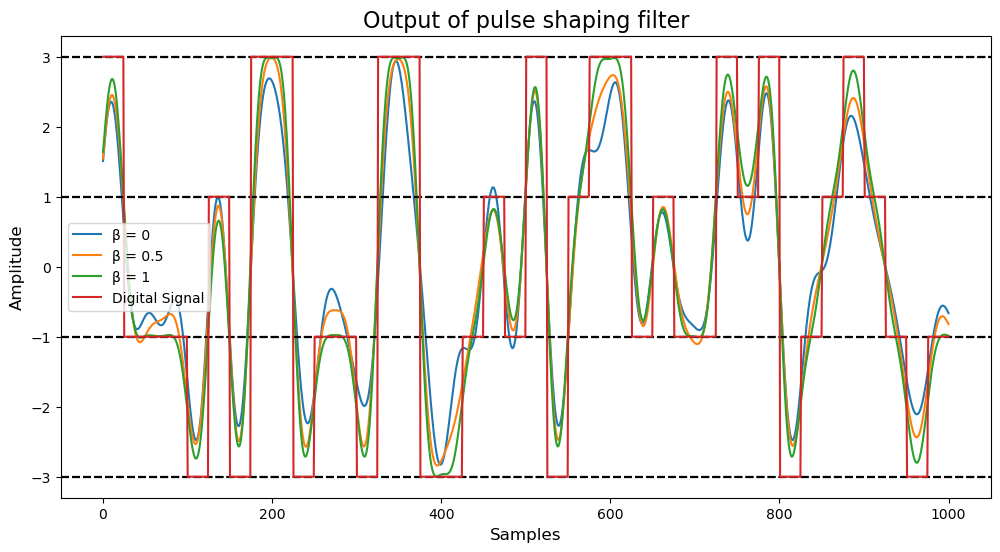

In [175]:
# using Raised Cosine Pulse

# Test parameters
SpS = 10
β = [0, 0.5, 1]
T = 1
ns = 100

# plot generation

figure5 = plt.figure( figsize=(12,6)) 

for i in range(len(β)):
    t = np.linspace(0, ns*T*SpS, ns*SpS)
    pulse = raised_cosine_pulse(SpS, β[i], T, ns)
        
    conv = sci.convolve(signal,pulse) # convoluting the filter and signal

    conv = conv[500:] # Removing the first symbols of the convolution due to
                      # trash data introduced by the beginning of the RC pulse
    

    plt.plot(t[0:1000],conv[0:1000]*3/conv.max(), label = 'β = '+str(β[i])) #normalizing the convolution function gain 
    plt.xlabel('Samples', fontsize = 12)
    plt.ylabel('Amplitude', fontsize = 12)
    plt.title('Output of pulse shaping filter', fontsize = 16)
    plt.axhline(y=3, color ='k', linestyle = '--')
    plt.axhline(y=1., color ='k', linestyle = '--')
    plt.axhline(y=-1, color ='k', linestyle = '--')
    plt.axhline(y=-3, color ='k', linestyle = '--')

plt.plot(t,signal[0:1000], label = 'Digital Signal')
plt.legend();

Observing the generated plot, it's evident that the raised cosine (RC) pulses do not introduce inter-symbol interference (ISI) in this scenario. Consequently, the optimal sampling moments are distinctly visible at the center of each pulse.